# Project 1: Regression and Model Selection

In this project, you will construct a (linear) regression model, and apply it to a synthetic task as well as a real-world house value prediction task.

## Objectives
Your goal in this project is to get comfortable in implementing a complete supervised learning pipeline (in Python). To complete this project, you should understand the following:

* How to use basic math and machine learning modules in python such as numpy, matplotlib, and sklearn (*_You are encouraged to use numpy to vectorize array operations [see link](https://numpy.org/doc/stable//user/absolute_beginners.html#basic-array-operations)_*)
* How to train a regression model *from scratch*
* How to implement the *gradient descent* algorithm for iterative model update
* How to perform model section when facing multiple choices
* How to evaluate the test results and visualize the outcome of an ML model

## Deliverable
* Project report/writeup: A `project1_report_lastname.pdf` file with corresponding plots and results for the project. Follow the `Project 1 - Report (Individual Submission)` link on Gradescope to upload this file. The project report should include a brief justification of your solution at a high-level, e.g., using any relevant explanations, equations, or pictures that help to explain your solution. You should also describe what your code does, e.g. using a couple of sentences per function to describe your code structure. 

* Source code: A `project1_src_lastname1[_lastname2].ipynb` (or `.zip`) file with a working copy of your solutions compiled in a Jupyter notebook. Follow the `Project 1 - Source Code (Group Submission)` link to upload this file.


## Logistics

* You can work in groups of 1-2 students for each course project, and it's your responsibility to find a group (e.g. use Ed Discussion). 
* Every member of a group must complete and submit the project report/writeup individually. While the source code can be the same for all group members, the project report needs to be written independently by each person and, thus, should differ among team member and students more generally.
* One one group member need to submit the source code. If you submit as a group, make sure to include your teammate in the group submission. Instructions for team submission can be found [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
* Grades will be provided based on the individual project report. The source code submission will not be graded, but the teaching staff may check the source files if they see the need for reproducing your results when going through your project report. 
* Failure to submit the source code will lead to a deduction of points from your total.


## Task 1A: (Warmup) Linear Regression on Synthetic Dataset, *from Scratch*

### Loading math, machine learning, and visualization modules
We start importing some modules and running some magic commands

In [91]:
%matplotlib inline

# General math and plotting modules.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Machine Learning library. 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Utility/helper functions for generating synthetic dataset, plots, etc.

Below are a few utility functions for generating plots (you don't have to modify these functions).

In [92]:
def generate_polynomial_data(num_points, noise, w):
    dim = w.size - 1
    # Generate feature vector 
    
    # We often use np.random.seed for repeatability; 
    # remove it if you want to inject randomness into your results 
    np.random.seed(42)

    x = np.random.normal(size=(num_points, 1))
    x1 = np.power(x, 0)
    for d in range(dim):
        x1 = np.concatenate((np.power(x, 1 + d), x1), axis=1)  # X = [x, 1].
    y = np.dot(x1, w) + np.random.normal(size=(num_points,)) * noise  # y = Xw + eps

    return x1, y

def plot_data(X, Y, fig=None, options=dict()):
    if fig is None:
        fig = plt.subplot(111)
    fig.plot(X, Y, options.get('marker', 'b*'), 
        label=options.get('label', 'Raw data'),
        fillstyle=options.get('fillstyle', 'full'),
        ms=options.get('size', 8))
    process_plot(fig, options)

def plot_fit(X, w, fig=None, options=dict()):
    if fig is None:
        fig = plt.subplot(111)

    x_min = np.min(X[:, -2])
    x_max = np.max(X[:, -2])
    dim = w.size - 1
    x_plot = np.reshape(np.linspace(x_min, x_max, 100), [-1, 1])
    x1_plot = np.ones_like(x_plot)
    for d in range(dim):
        x1_plot = np.concatenate((np.power(x_plot, 1 + d), x1_plot), axis=1)

    y_plot = np.dot(x1_plot, w)
    fig.plot(x_plot, y_plot, 'r-', label=options.get('label', 'Regression fit'))
    process_plot(fig, options)

def process_plot(fig, options=dict()):
    if 'x_label' in options.keys():
        fig.set_xlabel(options['x_label'])
    if 'y_label' in options.keys():
        fig.set_ylabel(options['y_label'])
    if 'x_lim' in options.keys():
        fig.set_ylim(options['x_lim'])
    if 'y_lim' in options.keys():
        fig.set_ylim(options['y_lim'])
    if 'title' in options.keys():
        fig.set_title(options['title'])
    if 'legend' in options.keys():
        if options['legend']:
            fig.legend(loc=options.get('legend_loc', 'best'))

### Data loader

Loading and processing dataset (you don't have to modify these functions).

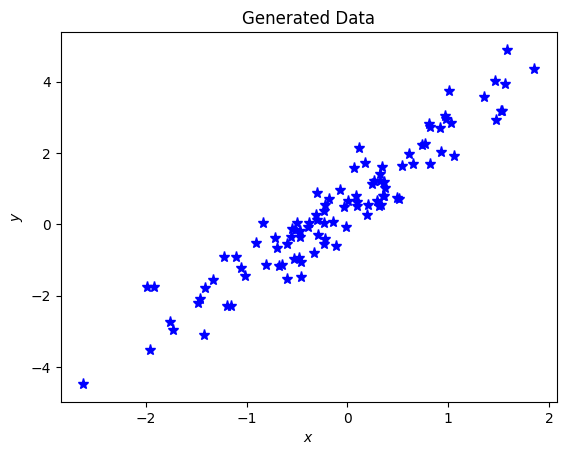

In [93]:
# Generate the data.
num_points = 100  # Number of training points.
noise = 0.6  # Noise Level (needed for data generation).

w_true = np.array([2, 0.6]) # groundtruth function parameter

X, y = generate_polynomial_data(num_points, noise, w_true) # y = X w_true + noise

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

# Plot Data
fig = plt.subplot(111);
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Generated Data', 'y_lim': [np.min(y)-0.5, np.max(y)+0.5]}
plot_data(X[:, 0], y, fig=fig, options=plot_opts)

### Modeling (30pt)

In the following, you will write you own loss function for this linear regression task. This could be later used for the regression applications in Task 1B.


### The key ingredient of modeling: risk (i.e. expected loss) function and its gradient

We will start by fitting by linear regression a set of data points of the type $D = \left\{(\mathbf{x}, y)_i\right\}$, $i \in \{1, 2, \ldots, n\}$.

The objective of linear regression, is to find coefficents $\hat{w}$ such that the residual between $\hat{y} = \hat{\mathbf{w}}^\top \tilde{\mathbf{x}}$, and $y$ is small. (Remember that $\tilde{\mathbf{x}} = [\mathbf{x}, 1]$). From now on, $\mathbf{x}$ will be considered the extended version unless stated otherwise, hence dropping the tilde notation. 

We consider the ridge regression risk function, defined as 
$$ R({\mathbf{w}}) = \mathbb{E}[(y-{\mathbf{w}}^\top x)^2)] +  \lambda \mathbf{w}^\top \mathbf{w}$$

where the expectation is taken over the data generating the distribution of points. As the whole data generating distribution is not known, the expectation is approximated by samples from the **training** set. 

The risk is approximated by the *empirical risk* as:


$$\hat{R}_{\text{ridge}}(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n \left(y_i - \mathbf{w}^\top \mathbf{x}_i\right)^2 + \lambda \mathbf{w}^\top \mathbf{w}$$

In the following, construct a customized funciton which returns the empirical risk and its gradient at parameter $\theta$:

In [94]:
# Constructing the empirical risk function for ridge regression.
def lossFunction(theta, X, y ,Lambda):
    """
    Take in numpy array of theta, X, and y to return the regularize loss function and gradient
    of a logistic regression
    """
    # initialize regularized average loss (empirical risk) and its gradient
    regLoss = 0
    grad = np.zeros(theta.shape)

    n = len(y)
    y = y.reshape(-1,1)
    regLoss = (1/n) * np.sum(np.power(y - X@theta,2)) + Lambda*(theta.T@theta)
    grad = -2/n* X.T@(y - X@theta) + 2*Lambda*theta
    return regLoss, grad

# Initialize fitting parameters
initial_theta = np.zeros((X.shape[1], 1))
print(initial_theta)

# Set regularization parameter lambda
Lambda = 0.1

#Compute and display initial loss and gradient for regularized logistic regression
emp_risk, grad=lossFunction(initial_theta, X, y, Lambda)
print("Loss at initial theta (zeros):",emp_risk)

[[0.]
 [0.]]
Loss at initial theta (zeros): [[3.47407884]]


### Training your ridge regressor: Gradient descent (15pt)

There are many algorithmic tools for training your classifier. Here, we use the popular gradient descent algorithm:

The parameters $\hat{\mathbf{w}}$ can be updated via a gradient descent rule: 

$$ \hat{\mathbf{w}}_{k+1} \gets \hat{\mathbf{w}}_k - \eta_k \left.\frac{\partial \hat{R}}{\partial \mathbf{w}} \right|_{\mathbf{w}=\mathbf{w}_k},$$

where $\eta_k$ is a parameter of the algorithm, $k$ is the iteration index, and $\frac{\partial \hat{R}}{\partial \mathbf{w}}$ is the gradient of the empirical risk function w.r.t. $\mathbf{w}$.

In the *vanilla* gradient descent method, $\eta(k)=\eta_0$ is a constant. However other algorithms exists that modify this.

The computational complexity of Gradient descent is $O(n_{\text{iter}} \cdot  n d)$. 


Write a customized function `gradientDescent(X,y,theta,eta,Lambda,tolerance)`
 which returns an array of empirical risk values, one for each iteration, as well as the final output of the model parameter. 
 
 Here, `tollerance` specifies the stopping condition: The gradient descent algorithm terminates the observed loss values converges (i.e. two consective losses differ by at most `tollerance`). Hint: the loss should be descending in the loss plot.

The regularized theta using ridge regression:
 [[1.73301773]
 [0.57445939]]


Text(0.5, 1.0, 'Loss function using Gradient Descent')

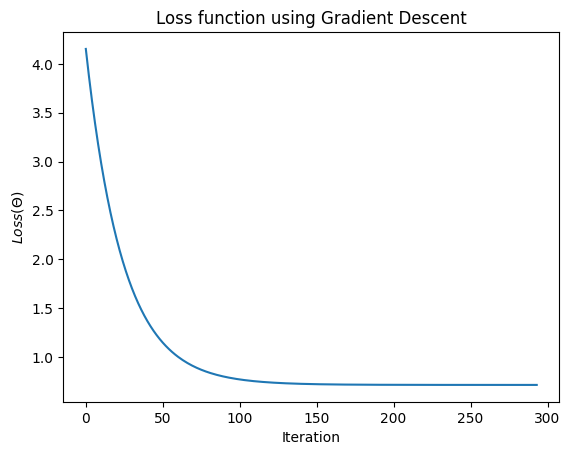

In [95]:
def gradientDescent(X,y,theta,eta,Lambda,tolerance):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of eta
    
    return theta and the list of the loss of theta during each iteration
    """
    Loss_history = []
    prev = 0 
    while True: 
        risk, grad = lossFunction(theta, X,y,Lambda)
        Loss_history.append(risk.flatten())
        if abs(prev - risk) < tolerance: 
            break 
        prev = risk 
        theta = theta - eta*grad     
    return theta, Loss_history
        

Eta = 0.01
Tolerance = 1e-6

theta, Loss_history = gradientDescent(X_train,y_train,initial_theta,Eta,Lambda,Tolerance)
print("The regularized theta using ridge regression:\n",theta)

plt.plot(Loss_history)
plt.xlabel("Iteration")
plt.ylabel("$Loss(\Theta)$")
plt.title("Loss function using Gradient Descent")


### Test module (5pt)

We still need a method to evaluate the model constructed. Here, we plot the predicted values on the test data, together with the training points.

Let's take a look at the final results.


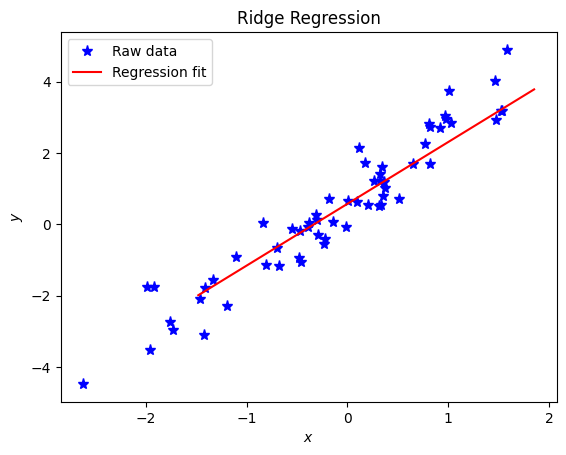

In [96]:
# Plot predicted function
fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Ridge Regression', 'legend': True,
                 'y_lim': [np.min(y)-0.5, np.max(y)+0.5]}

plot_data(X_train[:,0], y_train, fig=fig, options=plot_opts)
plot_fit(X_test, theta, fig=fig, options=plot_opts)


## Task 1B: Real Dataset: House Value Prediction

We will use the [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from the scikit-learn package. The task is to predict the house values in California districts given some summary stats about them based on the 1990 census data.

The dataset has 8 features: longitudes, latitudes, housing median age, total rooms, total bedrooms, population, households, median income, and median house value. The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($\$100,000$). We split the dataset as 80\% for training data and 20\% for testing data. 

The following script loads the dataset (using pandas dataframe):

In [97]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import pandas as pd

california=fetch_california_housing()
california_df=pd.DataFrame(california.data,columns=california.feature_names)
california_df['Price']=california.target
california_df 

newX=california_df.drop('Price',axis=1)
newY=california_df['Price']

newX = StandardScaler().fit_transform(newX)


Following the script below, you will be able to generate the training and test data.

In [98]:
N_train = len(newX) * .8

np.random.seed(150)
msk = np.random.rand(len(newX)) < 0.8

X_train, y_train = newX[msk], newY[msk]
X_test, y_test = newX[~msk], newY[~msk]

### Training and evaluation (25pt)

Write a function to fit the Ridge regression on the training data and calculate the MSE on the training set. Choosing $\lambda$ from $\{10^{-10}, 10^{-6}, 10^{-4}, 10^{-2}, 10^{-1}, 1, 10, 20, 50, 100\}$, compute the estimate $\hat{\mathbf{y}}$ for different values $\lambda$, and plot the test MSE as a function of $\lambda$. 


❗**Note**: You should write your own model fitting and prediction (following the ones you construct in Task 1A). You may call your customized function `lossFunction` and `gradientDescent`. Do not use `sklearn.linear_model` module (i.e. for model fitting and making predictions).

In [101]:
def train_and_eval( X_train , y_train , X_eval , y_eval , lambda_ ):
  
    mse = 0
    initial_theta = np.zeros((X_train.shape[1], 1))
    Eta = 0.01
    Tolerance = 1e-6
    learned, _ = gradientDescent(X_train, y_train,initial_theta,Eta,lambda_,Tolerance)
    print(learned)
    y_hat = X_eval @learned
    y_eval = y_eval.reshape((-1,1))
    mse = np.mean(np.power(y_eval - y_hat,2))
    return mse


weight_list = [1e-10, 1e-6, 1e-4, 0.01, 0.1, 1, 10, 20, 50, 100]
result_list = []

# compute test MSE
for weight in weight_list:
    test_mse = train_and_eval(X_train , y_train.to_numpy() , X_test , y_test.to_numpy(), weight)
    print(f"{weight=}, {test_mse=}")
    result_list.append([test_mse, weight])
    result_array = np.array (result_list)
    
# print(result_array)
plt.figure()
plt.plot( result_array [: , -1] , result_array [: ,0] , label = 'test mse')
plt.xlabel('lambda')
plt.ylabel('test mse')
plt.yscale('log')
plt.legend()
plt.show()

### Model selection via k-fold cross validation (25pt)

Implement *10-fold cross validation* on the training set to select $\lambda$. 

Plot and compare the MSE on the hold-out set with the true MSE which is computed on the test set. And see how we get to finding the ``best'' $\lambda$.

❗**Note:** For this subproblem, you should write your own function for cross validation; in particular, you should **not** call the existing `sklearn.model_selection` module.

In [ ]:
def cross_validation(X_train, y_train, lambda_, k=10):
    """
    Perform k-fold cross validation on X_train and y_train.
    """
    # add your code to perform k-fold cross validation
    #
    #
    #
    #
    return mse


# List of lambdas to try
weight_list = [1e-10, 1e-6, 1e-4, 0.01, 0.1, 1, 10, 20, 50, 100]

best_lambda = None
best_mse = np.inf

# Find the best lambda
for lambda_ in weight_list:
    print("cross validation with lambda: ", lambda_)
    mse = cross_validation(X_train, y_train, lambda_)
    if mse < best_mse:
        best_mse = mse
        best_lambda = lambda_

print("Best lambda: ", best_lambda)


cross validation with lambda:  1e-10


NameError: name 'mse' is not defined

# Bonus (10pt): Implementing LASSO Regression

In this bonus question, you will implement LASSO regression for [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html).

Following the previous notation, we consider the Lasso regression risk function, defined as 
$$ R({\mathbf{w}}) = \mathbb{E}[(y-{\mathbf{w}}^\top x)^2)] +  \lambda ||\mathbf{w}||_1$$

where the expectation is taken over the data generating the distribution of points. As the whole data generating distribution is not known, the expectation is approximated by samples from the **training** set. 

The risk is approximated by the *empirical risk* as:

$$\hat{R}_{\text{lasso}}(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n \left(y_i - \mathbf{w}^\top \mathbf{x}_i\right)^2 + \lambda ||\mathbf{w}||_1$$

In the following, construct a customized function which returns the empirical risk and its gradient at parameter $\theta$:

❗**Note**: You should write your own model fitting and prediction (following the ones you construct in Task 1A). You may call your customized function `lossFunctionLASSO`, `gradientDescent` and `train_and_eval`. Do not use `sklearn.linear_model` module (i.e. for model fitting and making predictions).

In [ ]:
# Constructing the empirical risk function for LASSO regression.
def lossFunctionLASSO(theta, X, y ,Lambda):
    """
    Take in numpy array of theta, X, and y to return the regularize loss function and gradient
    of a LASSO regression
    """
    # initialize regularized average loss (empirical risk) and its gradient
    regLoss = 0
    grad = np.zeros(theta.shape)

    # add your code to compute the LASSO regression risk function and its gradient #
    # 
     
    return regLoss, grad

def gradientDescent(X,y,theta,eta,Lambda,tolerance,max_iter=1000):
    # you can reuse your code from ridge regression and modify it accordingly #
    return theta, Loss_history

def train_and_eval( X_train , y_train , X_eval , y_eval , lambda_ ):
    # you can reuse your code from ridge regression and modify it accordingly #
    
    return mse


weight_list = [1e-10, 1e-6, 1e-4, 0.01, 0.1, 1, 10, 20, 50, 100]
result_list = []

# compute test MSE
for weight in weight_list:
    test_mse = train_and_eval ( X_train , y_train , X_test , y_test , weight )
    result_list.append ([ test_mse , weight ])
    result_array = np.array ( result_list )

plt.figure()
plt.plot( result_array [: , -1] , result_array [: ,0] , label = 'test mse')
plt.xlabel('lambda')
plt.ylabel('test mse')
plt.yscale('log')
plt.legend()
plt.show()